In [262]:
import numpy as np
def fetch(url):
    import requests, gzip, os, hashlib
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

<Figure size 432x288 with 0 Axes>

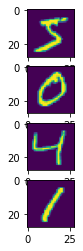

In [391]:
import matplotlib.pyplot as plt
%matplotlib inline

#image is a numpy array
# imshow(data1,data2)

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(4,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(X_train[0])
axarr[1].imshow(X_train[1])
axarr[2].imshow(X_train[2])
axarr[3].imshow(X_train[3])


In [392]:
import numpy as np
import random

In [393]:
X_train.shape



(60000, 28, 28)

In [394]:
ex =np.array([[[1,2,3],[4,5,6]], [[7,8,9],[10,11,12]]])
print(ex)
print(len(ex))
ex.shape
ex = ex.reshape(2,6)
ex

[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]
2


array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12]])

In [395]:
X_train.shape

(60000, 28, 28)

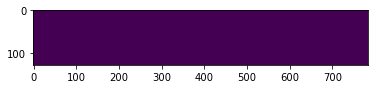

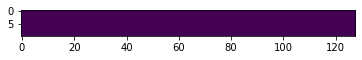

In [396]:
# numpy version

def logsumexp(x):
  #return np.log(np.exp(x).sum(axis=1))
  # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    c = x.max(axis=1)
    #print('c',c.shape)
    return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

# image put in to the layer as a batch(bunch)         
def forward(images,labels):
    
    out = np.zeros((len(labels),10), np.float32)
    out[range(out.shape[0]),labels] = 1

    # first layer 
    images_l1  = images.dot(w1) # 1st layer 6000* 784 x  784 * 128  = 6000* 128
    # ReLu activation
    images_relu  = np.maximum(images_l1,0) # relu activation 6000*128
    # 2nd layer
    images_l2 = images_relu.dot(w2) # 2nd layer 6000*128 x 128 * 10 = 6000*10 
    # loss 
    images_lsm = images_l2 - logsumexp(images_l2).reshape((-1, 1))
    images_loss = (-out * images_lsm).mean(axis=1)
    d_out =  -out/len(labels)
   


    # ** derivative ( back prop) **
    
    # derivative of log soft max 
    dx_lsm = d_out - np.exp(images_lsm)*d_out.sum(axis = 1).reshape((-1,1))
    # derivative of l2 layer 
    d_l2 = images_relu.T.dot(dx_lsm)
    dx_relu = dx_lsm.dot(w2.T)
    # derivative of relu
    dx_l1 = (images_relu > 0).astype(np.float32) * dx_relu

    # derivative of l1
    d_l1 = images.T.dot(dx_l1)
    
    return images_loss, images_l2, d_l1, d_l2


samp = [0,1,2,3]
images_loss, images_l2, d_l1, d_l2 = forward(X_test[samp].reshape((-1, 28*28)), Y_test[samp])

plt.imshow(d_l1.T)
plt.figure()
plt.imshow(d_l2.T)
    


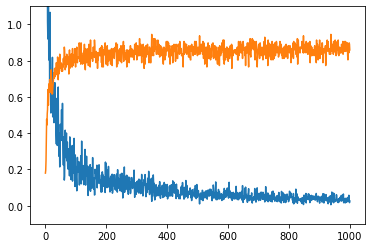

In [397]:
# numpy training 

def init_layer(m,n):
    res = np.random.uniform(-1.,1., size = (m,n))
    return res.astype(np.float32)

np.random.seed(1337)
w1 = init_layer(784,128) # initialize weight for l1
w2 = init_layer(128, 10) # initialize wiehgt for l2

lr = 0.001
batch_size = 128
losses = []
acces = []

for _ in range(1000):
    samp = np.random.randint(0,X_train.shape[0],size = (batch_size))
    # each sample is an array of batch_size of random integers 
    
    # for each sample (every single image in one batch), x will be the stack of 128 image array
    X = X_train[samp].reshape((-1,28*28))
    
    
    Y = Y_train[samp]

    x_loss, x_12,d_11,d_12 = forward(X,Y)
    
    cat = np.argmax(x_12,axis = 1)
    acc = (cat == Y).mean()
    
    # sgd
    w1 = w1-lr*d_11
    w2 = w2-lr*d_12
    
    loss = x_loss.mean()
    losses.append(loss/100)
    acces.append(acc)
#print(acces)
    

    
plt.ylim(-.1, 1.1)
plt.plot(losses)
plt.plot(acces)

In [398]:
# model eval with test data

def f(imgs):
    imgs = imgs.dot(w1)
    imgs = np.maximum(imgs,0)
    imgs = imgs.dot(w2)
    return imgs
def eval():
    Y_test_preds_out = f(X_test.reshape((-1, 28*28)))
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    return (Y_test == Y_test_preds).mean()
eval()

0.8518

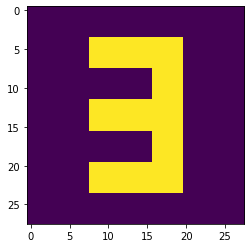

In [399]:
m = [[0,0,0,0,0,0,0],
     [0,0,1,1,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,1,1,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,1,1,1,0,0],
     [0,0,0,0,0,0,0]]
# upscale to 28x28
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
plt.imshow(m.reshape(28,28))

In [400]:
x = m.reshape(1, -1).dot(w1)
x = np.maximum(x, 0)
x = x.dot(w2)
np.argmax(x)


3